# Równoważenia obciążenia przez alokację shardów

Inicjalizacja środowiska

In [21]:
import pprint
import operator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

pp = pprint.PrettyPrinter(indent=1, width=140)
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = [7, 4]

Inicjalizacja wektora obciążeń poszczególnych shardów (F)

In [2]:
np.random.seed(23456789)

F_base = np.random.normal(loc=7, scale=1, size=(250, 100))
pp.pprint(F_base)
print(np.array(F_base).shape)

array([[7.66453587, 6.66192441, 5.3615201 , ..., 6.67318347, 6.75706923,
        6.30120981],
       [6.64067853, 7.08540122, 6.97698422, ..., 7.97566644, 5.15715268,
        8.13467868],
       [5.61516121, 7.86733846, 7.14924725, ..., 6.93862102, 6.51528925,
        6.64301763],
       ...,
       [7.55740116, 7.74622129, 7.02576209, ..., 5.21576001, 7.08451006,
        7.8925802 ],
       [6.4150077 , 7.98062436, 8.19110333, ..., 6.96241988, 6.22493088,
        9.27937388],
       [7.82828069, 8.69654393, 6.30657381, ..., 7.22951842, 8.43510218,
        7.19773342]])
(250, 100)


Rozkład wartości

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


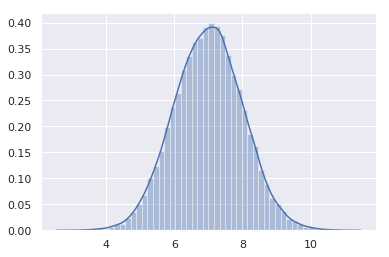

In [3]:
F_base_arr = np.array(F_base)
histogram = np.histogram(F_base_arr.flatten('F'), density=True)
sns.distplot(F_base_arr.flatten('F'));

Wyznaczenie ilości węzłów chmury (n)

In [4]:
n = 30

Wyznaczenie sumarycznego wektora obciążenia całej chmury

In [5]:
wts = list(map(sum, zip(*F_base)))

Wyznaczenie względnego obciążenia przypadającego na jeden węzeł chmury

In [6]:
nwts = sum(list(wts))

Sortowanie względem modułu

In [7]:
F=sorted([x * n for x in F_base],key=sum, reverse=True)

Alokowanie wektorów shardów względem posortowanego obciążenia

In [8]:
N = [[0 for y in F[x]] for x in range(0, n)]
R1 = [[0 for y in F[x]] for x in range(0, n)]

for R1_index, shard in enumerate(F):
    abs1 = sum(list(map(abs,list(map(operator.sub, wts,shard)))))
    maxValue = None
    maxNodeIndex = None

    for index, node in enumerate(N):
        
        if(sum(node) >= nwts):
            continue
            
        temp = [node,shard]
        abs2 =  sum(list(map(abs,map(operator.sub, wts, [sum(x) for x in zip(*temp)]))))
        value=abs2-abs1
        
        if(maxValue is None or value > maxValue):
            maxValue=value
            maxNodeIndex=index
    
    # suma dwoch wektorow
    N[maxNodeIndex]=list(map(operator.add, N[maxNodeIndex], list(shard)))
    
    # przydzielanie shardow losowe
    R1[R1_index%n]=list(map(operator.add, R1[R1_index%n], F_base[R1_index]))
    

#powrocenie do zmniejszonej o n 
N=[[x/n for x in f] for f in N]

Określenie średniej mocy chmury

In [9]:
power = 30

Wyznaczenie średniego obciążenia w czasie każdego węzła chmury(algorytm vs losowy przydział)

<IPython.core.display.Javascript object>


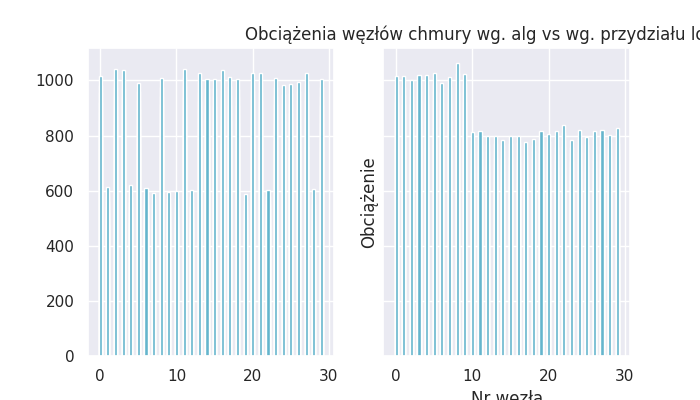

In [22]:
width = 0.4
Narray = np.transpose(np.array(N))
NR1array = np.transpose(np.array(R1))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

plt.xlabel("Nr węzła")
plt.ylabel("Obciążenie")
plt.title("Obciążenia węzłów chmury wg. alg vs wg. przydziału losowego")

ind = np.arange(n)
for index, value in enumerate(N):
    ax1.bar(range(0,n ), list(Narray[index]), width)
    ax2.bar(range(0,n ), list(NR1array[index]), width)

plt.show()

Wyznaczenie średniego przeciążenia każdego węzła chmury

In [11]:
loadN = list()
for node in N:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-power
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadN.append(nodeLoad)

Wyznaczenie średniego przeciążenia każdego węzła dla losowego przydziału

In [12]:
loadR1 = list()
for node in R1:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-power
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadR1.append(nodeLoad)

Opóźnienia z algorytmem

In [13]:
print(sum(loadN)/n)

143011.9481556997


Opóźnienia przydzielanie losowe

In [14]:
print(sum(loadR1)/n)

143011.94815569973


<IPython.core.display.Javascript object>


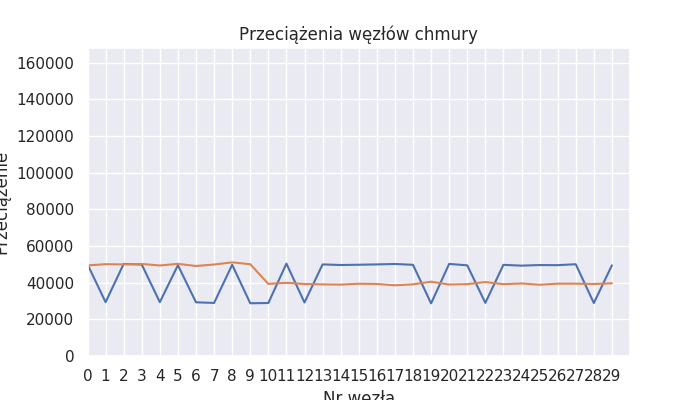

In [23]:
loadN_powerRelated = [x/(len(F_base[0]))*power for x in loadN]
plt.plot(loadN_powerRelated)

loadR1_powerRelated = [x/(len(F_base[0]))*power for x in loadR1]
plt.plot(loadR1_powerRelated)

plt.xlabel("Nr węzła")
plt.ylabel("Przeciążenie")
plt.axis([0, n, 0, max(loadN)])
plt.xticks(range(0,n))
plt.title("Przeciążenia węzłów chmury")
plt.show()